In [1]:
pip install -q git+https://github.com/tensorflow/examples.git


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras
from keras import backend as K


from IPython.display import clear_output
import matplotlib.pyplot as plt

import cv2
from tensorflow.keras.preprocessing.image import array_to_img, load_img, img_to_array
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat

In [3]:
def hair_remove(image):
    img = array_to_img(image)
    
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    # convert image to grayScale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
   
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
  
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(img,threshold,1,cv2.INPAINT_TELEA)
    final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    
    return final_image.astype(np.float64)/255.0

In [15]:
def generator(filenames):
    filenames = [file[:3] for file in filenames]
    folder_img = '../input/origalist/Images/Images'
    folder_masks = '../input/origalist/Semi-automatic-annotations/Semi-automatic-annotations'
    def callable_generator():
        for filename in filenames:
            
            img_file = os.path.join(folder_img, filename+'.jpg')
            mat_file = os.path.join(folder_masks, filename+'.mat')

            mat = loadmat(mat_file)
            mask = mat['mask'].reshape(2048, 3072, 1)
            mask_img = array_to_img(mask, scale=False)
            mask_img = mask_img.resize((512, 512))
            mask = np.array(mask_img).reshape(512, 512, 1)
#             mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
#             for i in range(512):
#                 for j in range(512):
#                     mask[i][j] = np.eye(3)[mask[i][j][0]]

            img = load_img(img_file, target_size=(512, 512))
            img = img_to_array(img)/255.0
            img_preprocessed = hair_remove(img)
            
            
            yield img_preprocessed, mask
            
    return callable_generator

In [16]:
csv_path = '../input/origalist/OrigaList.csv'
df = pd.read_csv(csv_path)
df.head()

,Eye,Filename,ExpCDR,Set,Glaucoma
0,OD,001.jpg,0.7097,A,0
1,OS,002.jpg,0.6953,A,0
2,OS,003.jpg,0.9629,A,0
3,OD,004.jpg,0.7246,A,0
4,OS,005.jpg,0.6138,A,0


In [17]:
train_dataset = tf.data.Dataset.from_generator(generator(df['Filename']),
                                              (tf.float32, tf.float32), ((512, 512, 3), (512, 512, 1)))

In [18]:
@tf.function
def load_image_train(input_image, input_mask):
    # a simple augmentation during training
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    return input_image, input_mask

In [19]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train.cache().shuffle(100).batch(16).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [20]:
TRAIN_LENGTH = 650
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [21]:
OUTPUT_CHANNELS = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[512, 512, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64 256
    'block_3_expand_relu',   # 32x32 128
    'block_6_expand_relu',   # 16x16 64
    'block_13_expand_relu',  # 8x8   32
    'block_16_project',      # 4x4   16
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [22]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8  32
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16  64
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32  128
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64  256
]

In [23]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 10 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=3)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_coef_9cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_9cat(y_true, y_pred)

In [77]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=dice_coef_9cat_loss,
              metrics=['accuracy'])

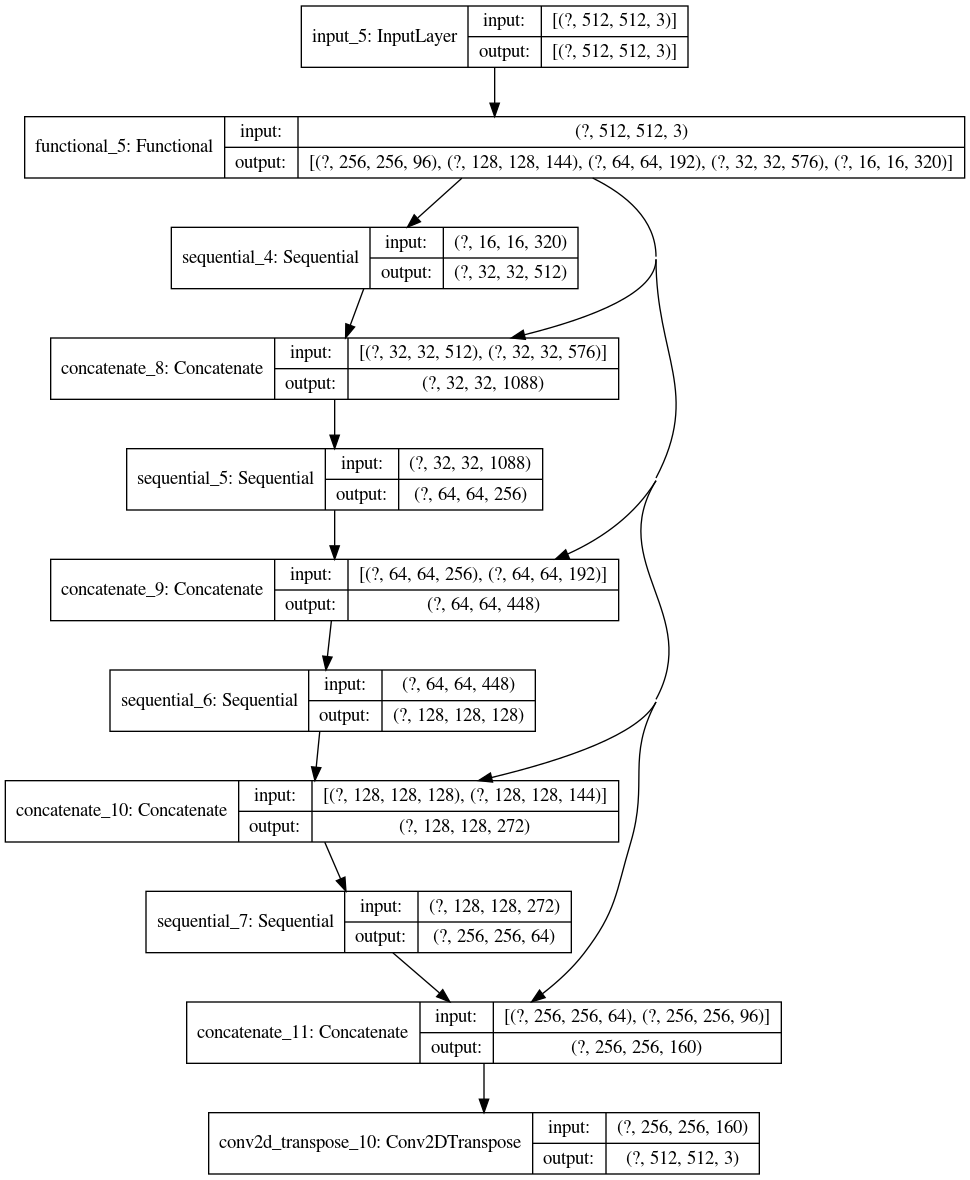

In [78]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [79]:
EPOCHS = 3

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/3
40/40 [==============================] - 10s 247ms/step - loss: 0.6215 - accuracy: 0.8335
Epoch 2/3
40/40 [==============================] - 10s 246ms/step - loss: 0.1832 - accuracy: 0.9960
Epoch 3/3
40/40 [==============================] - 10s 245ms/step - loss: 0.1714 - accuracy: 0.9961


In [81]:
model.save('working_model.h5')

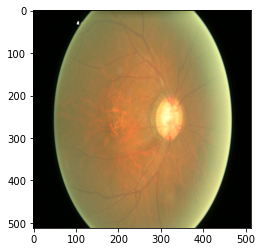

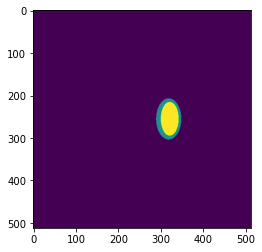

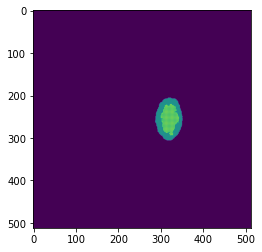

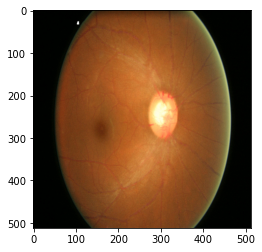

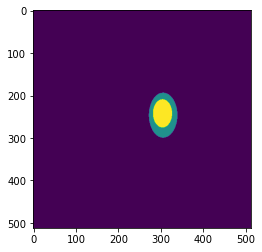

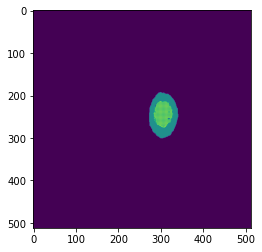

In [80]:
for img, mask in train_dataset.take(2):
    plt.imshow(img[0])
    plt.show()
    plt.imshow(np.array(mask[0]).reshape(512, 512))
    plt.show()
    pred = model.predict(img)
    my_mask = np.zeros((512, 512))
    for i in range(512):
        for j in range(512):
            my_mask[i][j] = np.argmax(pred[0][i][j])

    plt.imshow(my_mask.reshape(512, 512))
    plt.show()

In [72]:
def get_segmentation(file, model):
    
    test_img = load_img(test_file, target_size=(512, 512))
    test_img_fullsize = load_img(test_file)
    full_arr = np.array(test_img_fullsize)/255.0
    x_true = full_arr.shape[0]
    y_true = full_arr.shape[1]
    plt.imshow(test_img_fullsize)
    plt.show()
    
    test_arr = img_to_array(test_img)/255.0
    
    test_arr_preprocessed = hair_remove(test_arr)
#     plt.imshow(test_img)
#     plt.show()
    pred = model.predict(test_arr_preprocessed.reshape(1, 512, 512, 3))
    single_pred = pred[0]
    mask_img = array_to_img(single_pred)
    mask_img = mask_img.resize((y_true, x_true))
#     plt.imshow(mask_img)
#     plt.show()
    mask_arr = np.array(mask_img)/255.0

    
    
    
    my_mask = np.zeros((x_true, y_true))
    marked = []
    for i in range(x_true):
        for j in range(y_true):
            my_mask[i][j] = np.argmax(mask_arr[i][j])
            if np.argmax(mask_arr[i][j]) == 1:
                marked.append([i, j])
    avgi = []
    avgj = []
    for lis in marked:
        first = lis[0]
        sec = lis[1]
        avgi.append(first)
        avgj.append(sec)
        full_arr[first][sec] = [0.0, 0.0, 1.0]
        
    avgi = sum(avgi)//len(avgi)
    avgj = sum(avgj)//len(avgj)
    plt.imshow(full_arr)
    
    return (avgi, avgj)